# Análise do Dataset de Diabetes

Este projeto realiza uma análise completa do dataset de diabetes disponível no scikit-learn. 
O objetivo é prever a progressão da doença após um ano com base em 10 variáveis biológicas.

**Fonte dos dados:** sklearn.datasets.load_diabetes

**Objetivo:** Construir e comparar modelos de regressão para prever a progressão da diabetes.

## 1. Sobre o Dataset

O dataset de diabetes contém:
- **442 amostras** de pacientes
- **10 variáveis preditoras** (features): idade, sexo, IMC, pressão arterial média e 6 medidas de soro sanguíneo
- **1 variável alvo**: medida quantitativa da progressão da doença um ano após o baseline

**Características:**
- Todas as features foram centralizadas e normalizadas
- É um problema de **regressão** (prever um valor contínuo)
- Dataset clássico para aprendizado de máquina

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

print('✓ Bibliotecas importadas com sucesso!')

✓ Bibliotecas importadas com sucesso!


## 2. Carregando o Dataset

Vamos carregar o dataset de diabetes e explorar sua estrutura inicial.

In [109]:
# Carregando o dataset
diabetes = load_diabetes()

# Criando um DataFrame para facilitar a análise
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df['target'] = diabetes.target

print("Dimensões do dataset:", df.shape)
print("\nPrimeiras 5 linhas:")
print(df.head())
print("\nInformações sobre o dataset:")
print(df.info())
print("\nEstatísticas descritivas:")
print(df.describe())

Dimensões do dataset: (442, 11)

Primeiras 5 linhas:
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0  

Informações sobre o dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float6

In [110]:
# ==========================================
# FUNÇÃO PARA HUMANIZAR OS DADOS
# ==========================================

# Valores de referência médicos típicos (média e desvio padrão)
# Baseados em literatura médica para população com diabetes
reference_values = {
    'age': {'mean': 48, 'std': 13, 'unit': 'anos', 'name': 'Idade'},
    'sex': {'mean': 0, 'std': 1, 'unit': '', 'name': 'Sexo'},  # Binário
    'bmi': {'mean': 26.4, 'std': 4.4, 'unit': 'kg/m²', 'name': 'IMC'},
    'bp': {'mean': 94, 'std': 14, 'unit': 'mmHg', 'name': 'Pressão Arterial'},
    's1': {'mean': 189, 'std': 34, 'unit': 'mg/dL', 'name': 'Colesterol Total'},
    's2': {'mean': 115, 'std': 30, 'unit': 'mg/dL', 'name': 'LDL'},
    's3': {'mean': 49, 'std': 12, 'unit': 'mg/dL', 'name': 'HDL'},
    's4': {'mean': 4.1, 'std': 1.3, 'unit': '', 'name': 'Colesterol Total/HDL'},
    's5': {'mean': 4.9, 'std': 0.5, 'unit': 'log', 'name': 'Triglicerídeos (log)'},
    's6': {'mean': 91, 'std': 11, 'unit': 'mg/dL', 'name': 'Glicose'}
}

def z_to_real(z_score, feature):
    """Converte z-score para valor aproximado real"""
    if feature not in reference_values:
        return z_score
    
    ref = reference_values[feature]
    real_value = z_score * ref['std'] + ref['mean']
    return real_value

def humanize_patient(patient_row):
    """Converte uma linha do dataframe em valores humanizados"""
    humanized = {}
    
    for feature in diabetes.feature_names:
        if feature == 'sex':
            humanized['Sexo'] = 'Masculino' if patient_row['sex'] > 0 else 'Feminino'
        else:
            real_val = z_to_real(patient_row[feature], feature)
            ref = reference_values[feature]
            humanized[ref['name']] = f"{real_val:.1f} {ref['unit']}"
    
    humanized['Progressão da Diabetes'] = f"{patient_row['target']:.1f}"
    
    return humanized

# Criar DataFrame humanizado completo
df_humanized = pd.DataFrame()

for feature in diabetes.feature_names:
    if feature == 'sex':
        df_humanized['Sexo'] = df['sex'].apply(lambda x: 'Masculino' if x > 0 else 'Feminino')
    else:
        df_humanized[reference_values[feature]['name']] = df[feature].apply(
            lambda x: z_to_real(x, feature)
        )

df_humanized['Progressão'] = df['target']

print("✅ Função de humanização criada!")
print("\n📊 Primeiras 5 linhas HUMANIZADAS:")
print(df_humanized.head())

✅ Função de humanização criada!

📊 Primeiras 5 linhas HUMANIZADAS:
       Idade       Sexo        IMC  Pressão Arterial  Colesterol Total  \
0  48.494987  Masculino  26.671463         94.306213        187.496401   
1  47.975534   Feminino  26.173514         93.631415        188.712743   
2  49.108886  Masculino  26.595585         93.920614        187.449619   
3  46.842182   Feminino  26.348982         93.486815        189.414479   
4  48.069980   Feminino  26.239907         94.306213        189.133785   

          LDL        HDL  Colesterol Total/HDL  Triglicerídeos (log)  \
0  113.955377  48.479190              4.096630              4.909954   
1  114.425100  49.892939              4.048659              4.865834   
2  113.974166  48.611729              4.096630              4.901431   
3  115.749718  48.567549              4.144602              4.911344   
4  115.467884  49.097705              4.096630              4.884006   

     Glicose  Progressão  
0  90.805893       151.0  
1

In [111]:
print("=" * 80)
print("DADOS HUMANIZADOS - PRIMEIROS 5 PACIENTES")
print("=" * 80)

for i in range(5):
    print(f"\n{'='*80}")
    print(f"👤 PACIENTE {i+1}")
    print(f"{'='*80}")
    
    humanized = humanize_patient(df.iloc[i])
    
    for key, value in humanized.items():
        print(f"   {key:25s}: {value}")

DADOS HUMANIZADOS - PRIMEIROS 5 PACIENTES

👤 PACIENTE 1
   Idade                    : 48.5 anos
   Sexo                     : Masculino
   IMC                      : 26.7 kg/m²
   Pressão Arterial         : 94.3 mmHg
   Colesterol Total         : 187.5 mg/dL
   LDL                      : 114.0 mg/dL
   HDL                      : 48.5 mg/dL
   Colesterol Total/HDL     : 4.1 
   Triglicerídeos (log)     : 4.9 log
   Glicose                  : 90.8 mg/dL
   Progressão da Diabetes   : 151.0

👤 PACIENTE 2
   Idade                    : 48.0 anos
   Sexo                     : Feminino
   IMC                      : 26.2 kg/m²
   Pressão Arterial         : 93.6 mmHg
   Colesterol Total         : 188.7 mg/dL
   LDL                      : 114.4 mg/dL
   HDL                      : 49.9 mg/dL
   Colesterol Total/HDL     : 4.0 
   Triglicerídeos (log)     : 4.9 log
   Glicose                  : 90.0 mg/dL
   Progressão da Diabetes   : 75.0

👤 PACIENTE 3
   Idade                    : 49.1 anos
   Sex

## 3. Entendendo as Features Normalizadas

### 3.1 O que significam esses valores?

Os valores que você vê são **z-scores** (dados padronizados). Cada feature foi:
- **Centralizada** (média = 0)
- **Normalizada** (desvio padrão = 1)

**Significado das Features:**
- **age**: Idade
- **sex**: Sexo
- **bmi**: Índice de Massa Corporal (Body Mass Index)
- **bp**: Pressão arterial média (Blood Pressure)
- **s1**: tc, Colesterol total
- **s2**: ldl, Lipoproteína de baixa densidade
- **s3**: hdl, Lipoproteína de alta densidade
- **s4**: tch, Colesterol total / HDL
- **s5**: ltg, Triglicerídeos (log)
- **s6**: glu, Glicose

💡 **Como interpretar z-scores:**
- Valor próximo de **0**: próximo da média da população
- Valor **positivo**: acima da média
- Valor **negativo**: abaixo da média
- **|z| > 2**: valor extremo (muito acima ou muito abaixo)

In [112]:
# Informações completas sobre o dataset
print("=" * 80)
print("DESCRIÇÃO COMPLETA DO DATASET DE DIABETES")
print("=" * 80)
print(diabetes.DESCR)

DESCRIÇÃO COMPLETA DO DATASET DE DIABETES
.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: E

In [113]:
# Criando uma tabela mais interpretável
feature_info = pd.DataFrame({
    'Feature': diabetes.feature_names,
    'Descrição': [
        'Idade (normalizada)',
        'Sexo (normalizada)',
        'Índice de Massa Corporal',
        'Pressão Arterial Média',
        'Colesterol Total (S1)',
        'LDL - Lipoproteína Baixa Densidade (S2)',
        'HDL - Lipoproteína Alta Densidade (S3)',
        'Colesterol Total / HDL (S4)',
        'Triglicerídeos em log (S5)',
        'Glicose (S6)'
    ],
    'Média': df[diabetes.feature_names].mean().values,
    'Desvio Padrão': df[diabetes.feature_names].std().values,
    'Mínimo': df[diabetes.feature_names].min().values,
    'Máximo': df[diabetes.feature_names].max().values
})

print("\n📊 INFORMAÇÕES DAS FEATURES\n")
print(feature_info.to_string(index=False))


📊 INFORMAÇÕES DAS FEATURES

Feature                               Descrição         Média  Desvio Padrão    Mínimo   Máximo
    age                     Idade (normalizada) -1.444295e-18       0.047619 -0.107226 0.110727
    sex                      Sexo (normalizada)  2.543215e-18       0.047619 -0.044642 0.050680
    bmi                Índice de Massa Corporal -2.255925e-16       0.047619 -0.090275 0.170555
     bp                  Pressão Arterial Média -4.854086e-17       0.047619 -0.112399 0.132044
     s1                   Colesterol Total (S1) -1.428596e-17       0.047619 -0.126781 0.153914
     s2 LDL - Lipoproteína Baixa Densidade (S2)  3.898811e-17       0.047619 -0.115613 0.198788
     s3  HDL - Lipoproteína Alta Densidade (S3) -6.028360e-18       0.047619 -0.102307 0.181179
     s4             Colesterol Total / HDL (S4) -1.788100e-17       0.047619 -0.076395 0.185234
     s5              Triglicerídeos em log (S5)  9.243486e-17       0.047619 -0.126097 0.133597
     s6    

In [114]:
# Exemplo: Interpretando os primeiros 3 pacientes
print("=" * 80)
print("INTERPRETAÇÃO DOS PRIMEIROS 3 PACIENTES")
print("=" * 80)

for i in range(3):
    print(f"\n🔍 PACIENTE {i+1}:")
    print("-" * 80)
    
    patient = df.iloc[i]
    
    # Interpretação de cada feature
    if patient['age'] > 0:
        print(f"  • Idade: ACIMA da média (z-score: {patient['age']:.3f})")
    else:
        print(f"  • Idade: ABAIXO da média (z-score: {patient['age']:.3f})")
    
    if patient['sex'] > 0:
        print(f"  • Sexo: Masculino (z-score: {patient['sex']:.3f})")
    else:
        print(f"  • Sexo: Feminino (z-score: {patient['sex']:.3f})")
    
    if patient['bmi'] > 0:
        print(f"  • IMC: ACIMA da média - Sobrepeso/Obesidade (z-score: {patient['bmi']:.3f})")
    else:
        print(f"  • IMC: ABAIXO da média - Normal/Abaixo do peso (z-score: {patient['bmi']:.3f})")
    
    if patient['bp'] > 0:
        print(f"  • Pressão Arterial: ACIMA da média (z-score: {patient['bp']:.3f})")
    else:
        print(f"  • Pressão Arterial: ABAIXO da média (z-score: {patient['bp']:.3f})")
    
    print(f"  • Colesterol Total (S1): {patient['s1']:.3f}")
    print(f"  • LDL (S2): {patient['s2']:.3f}")
    print(f"  • HDL (S3): {patient['s3']:.3f}")
    print(f"  • Triglicerídeos (S5): {patient['s5']:.3f}")
    print(f"  • Glicose (S6): {patient['s6']:.3f}")
    print(f"\n  ➡️  Progressão da Diabetes: {patient['target']:.1f}")

INTERPRETAÇÃO DOS PRIMEIROS 3 PACIENTES

🔍 PACIENTE 1:
--------------------------------------------------------------------------------
  • Idade: ACIMA da média (z-score: 0.038)
  • Sexo: Masculino (z-score: 0.051)
  • IMC: ACIMA da média - Sobrepeso/Obesidade (z-score: 0.062)
  • Pressão Arterial: ACIMA da média (z-score: 0.022)
  • Colesterol Total (S1): -0.044
  • LDL (S2): -0.035
  • HDL (S3): -0.043
  • Triglicerídeos (S5): 0.020
  • Glicose (S6): -0.018

  ➡️  Progressão da Diabetes: 151.0

🔍 PACIENTE 2:
--------------------------------------------------------------------------------
  • Idade: ABAIXO da média (z-score: -0.002)
  • Sexo: Feminino (z-score: -0.045)
  • IMC: ABAIXO da média - Normal/Abaixo do peso (z-score: -0.051)
  • Pressão Arterial: ABAIXO da média (z-score: -0.026)
  • Colesterol Total (S1): -0.008
  • LDL (S2): -0.019
  • HDL (S3): 0.074
  • Triglicerídeos (S5): -0.068
  • Glicose (S6): -0.092

  ➡️  Progressão da Diabetes: 75.0

🔍 PACIENTE 3:
--------------

## 4. Análise Exploratória dos Dados (EDA)

### 4.1 Verificando Valores Faltantes

In [115]:
print("Valores faltantes por coluna:")
print(df.isnull().sum())
print("\nTotal de valores faltantes:", df.isnull().sum().sum())

Valores faltantes por coluna:
age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64

Total de valores faltantes: 0


### 4.2 Distribuição da Variável Alvo

Vamos visualizar como a progressão da diabetes está distribuída nos pacientes.

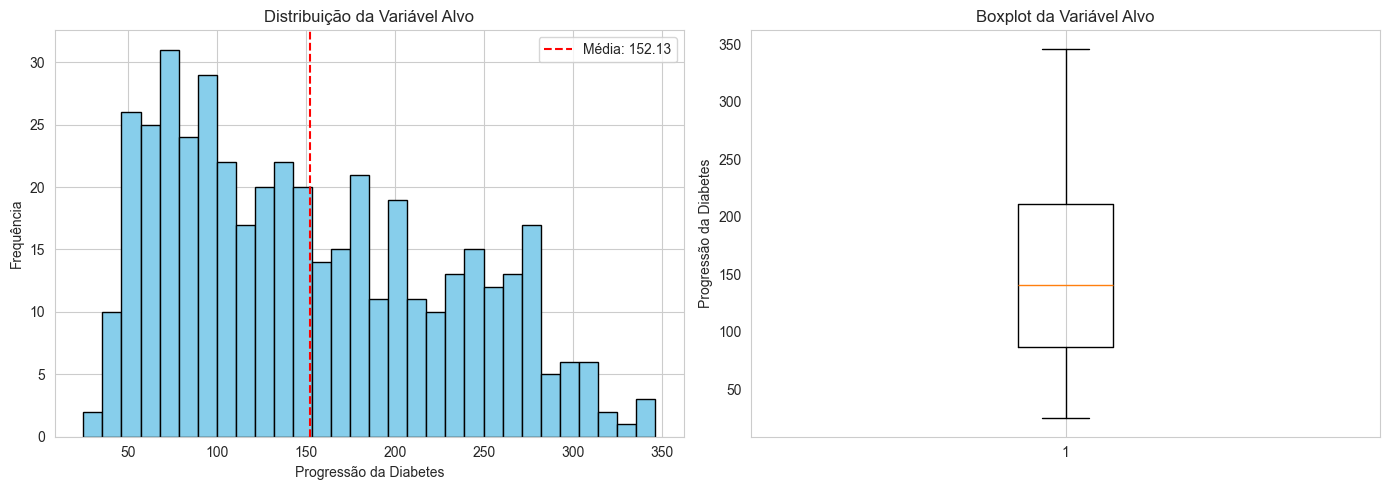

Média: 152.13
Mediana: 140.50
Desvio padrão: 77.09
Mínimo: 25.00
Máximo: 346.00


In [116]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(df['target'], bins=30, edgecolor='black', color='skyblue')
plt.xlabel('Progressão da Diabetes')
plt.ylabel('Frequência')
plt.title('Distribuição da Variável Alvo')
plt.axvline(df['target'].mean(), color='red', linestyle='--', 
            label=f'Média: {df["target"].mean():.2f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(df['target'], vert=True)
plt.ylabel('Progressão da Diabetes')
plt.title('Boxplot da Variável Alvo')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

print(f"Média: {df['target'].mean():.2f}")
print(f"Mediana: {df['target'].median():.2f}")
print(f"Desvio padrão: {df['target'].std():.2f}")
print(f"Mínimo: {df['target'].min():.2f}")
print(f"Máximo: {df['target'].max():.2f}")

INTERPRETAÇÃO HUMANIZADA DA PROGRESSÃO DA DIABETES

📊 CLASSIFICAÇÃO DOS PACIENTES:
   🟢 Baixa progressão (< 100):     147 pacientes (33.3%)
   🟡 Progressão moderada (100-200): 168 pacientes (38.0%)
   🔴 Alta progressão (> 200):       127 pacientes (28.7%)

💡 VALORES MÉDIOS POR GRUPO:

   Baixa Progressão:
      Idade média: 47.9 anos
      IMC médio: 26.3 kg/m²
      Glicose média: 90.8 mg/dL
      Colesterol médio: 188.6 mg/dL

   Moderada:
      Idade média: 48.0 anos
      IMC médio: 26.4 kg/m²
      Glicose média: 91.0 mg/dL
      Colesterol médio: 189.0 mg/dL

   Alta Progressão:
      Idade média: 48.1 anos
      IMC médio: 26.6 kg/m²
      Glicose média: 91.3 mg/dL
      Colesterol médio: 189.5 mg/dL


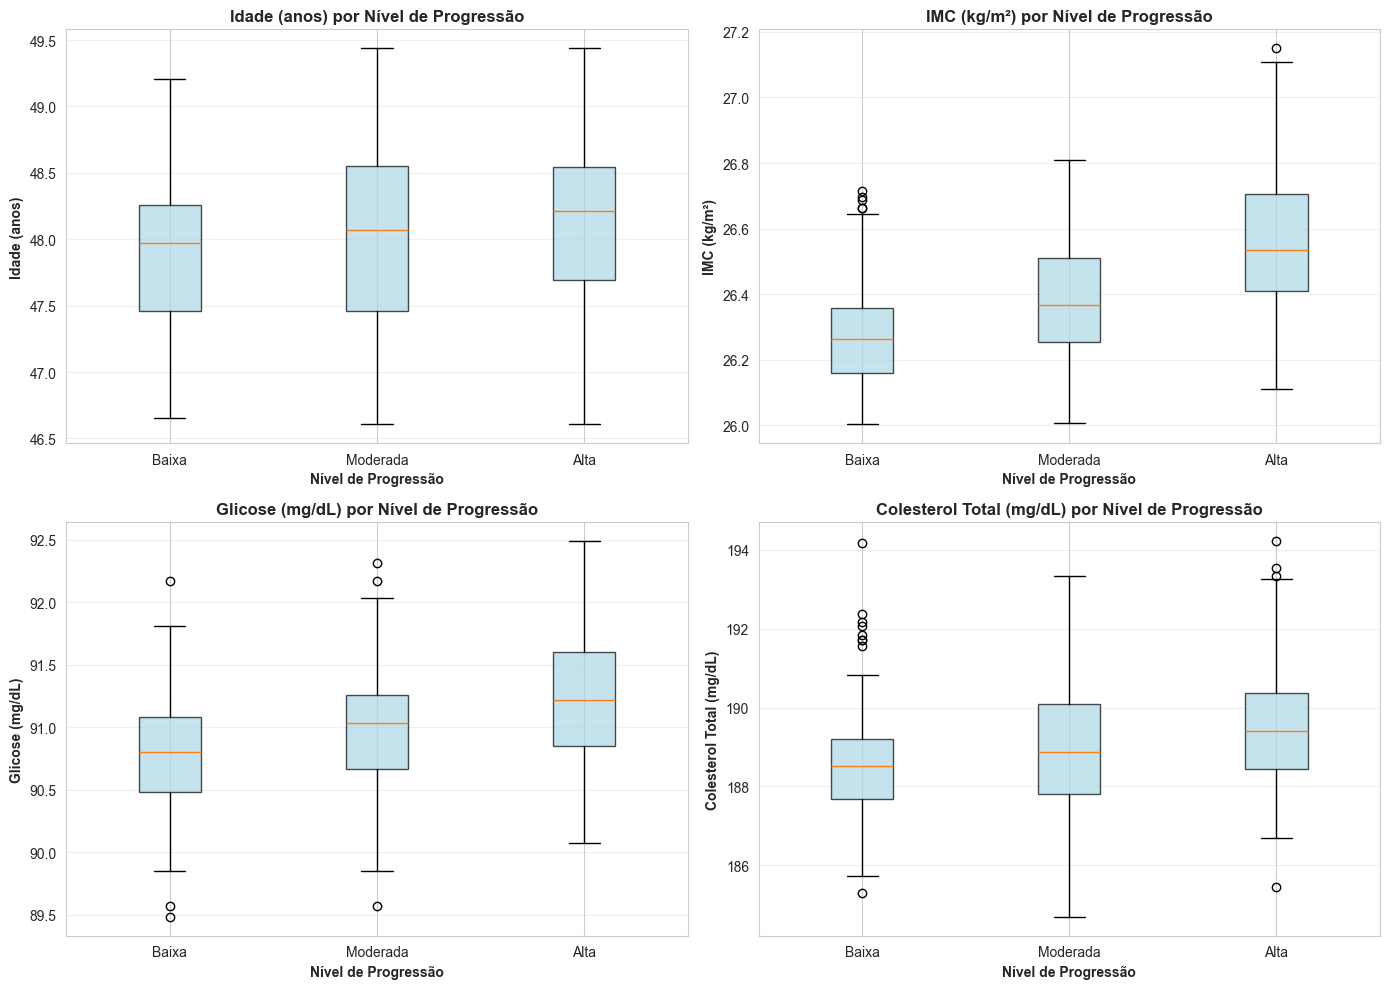

In [117]:
print("=" * 80)
print("INTERPRETAÇÃO HUMANIZADA DA PROGRESSÃO DA DIABETES")
print("=" * 80)

# Faixas de interpretação
baixa = df[df['target'] < 100]
moderada = df[(df['target'] >= 100) & (df['target'] < 200)]
alta = df[df['target'] >= 200]

print(f"\n📊 CLASSIFICAÇÃO DOS PACIENTES:")
print(f"   🟢 Baixa progressão (< 100):     {len(baixa):3d} pacientes ({len(baixa)/len(df)*100:.1f}%)")
print(f"   🟡 Progressão moderada (100-200): {len(moderada):3d} pacientes ({len(moderada)/len(df)*100:.1f}%)")
print(f"   🔴 Alta progressão (> 200):       {len(alta):3d} pacientes ({len(alta)/len(df)*100:.1f}%)")

print(f"\n💡 VALORES MÉDIOS POR GRUPO:")

for nome, grupo in [('Baixa Progressão', baixa), ('Moderada', moderada), ('Alta Progressão', alta)]:
    print(f"\n   {nome}:")
    print(f"      Idade média: {z_to_real(grupo['age'].mean(), 'age'):.1f} anos")
    print(f"      IMC médio: {z_to_real(grupo['bmi'].mean(), 'bmi'):.1f} kg/m²")
    print(f"      Glicose média: {z_to_real(grupo['s6'].mean(), 's6'):.1f} mg/dL")
    print(f"      Colesterol médio: {z_to_real(grupo['s1'].mean(), 's1'):.1f} mg/dL")

# Visualização comparativa
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

features_compare = [
    ('age', 'Idade (anos)'),
    ('bmi', 'IMC (kg/m²)'),
    ('s6', 'Glicose (mg/dL)'),
    ('s1', 'Colesterol Total (mg/dL)')
]

for idx, (feature, label) in enumerate(features_compare):
    ax = axes[idx // 2, idx % 2]
    
    # Converter z-scores para valores reais
    baixa_vals = [z_to_real(x, feature) for x in baixa[feature]]
    moderada_vals = [z_to_real(x, feature) for x in moderada[feature]]
    alta_vals = [z_to_real(x, feature) for x in alta[feature]]
    
    ax.boxplot([baixa_vals, moderada_vals, alta_vals], 
               labels=['Baixa', 'Moderada', 'Alta'],
               patch_artist=True,
               boxprops=dict(facecolor='lightblue', alpha=0.7))
    
    ax.set_ylabel(label, fontweight='bold')
    ax.set_xlabel('Nível de Progressão', fontweight='bold')
    ax.set_title(f'{label} por Nível de Progressão', fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3 Distribuição das Features Normalizadas

Vamos visualizar como cada feature está distribuída (todas com média 0 e desvio padrão 1).

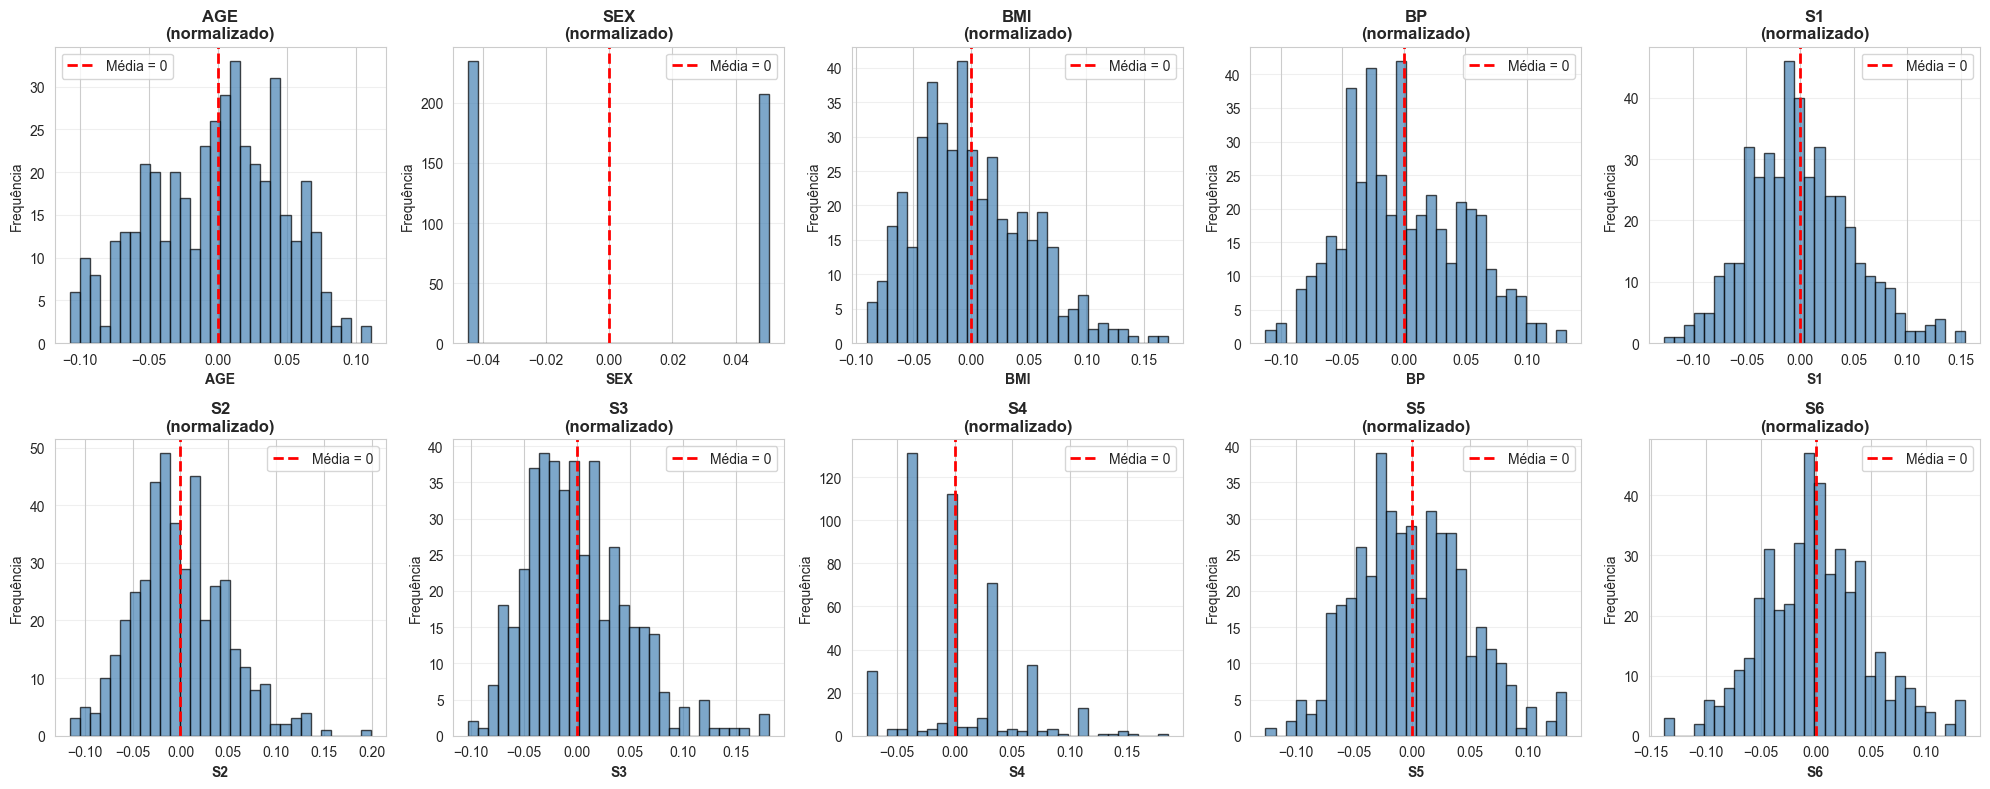

In [118]:
# Visualizando a distribuição de todas as features
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

for idx, feature in enumerate(diabetes.feature_names):
    axes[idx].hist(df[feature], bins=30, edgecolor='black', color='steelblue', alpha=0.7)
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='Média = 0')
    axes[idx].set_xlabel(feature.upper(), fontweight='bold')
    axes[idx].set_ylabel('Frequência')
    axes[idx].set_title(f'{feature.upper()}\n(normalizado)', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 4.4 Análise de Correlação

Vamos identificar quais variáveis têm maior correlação com a progressão da diabetes.

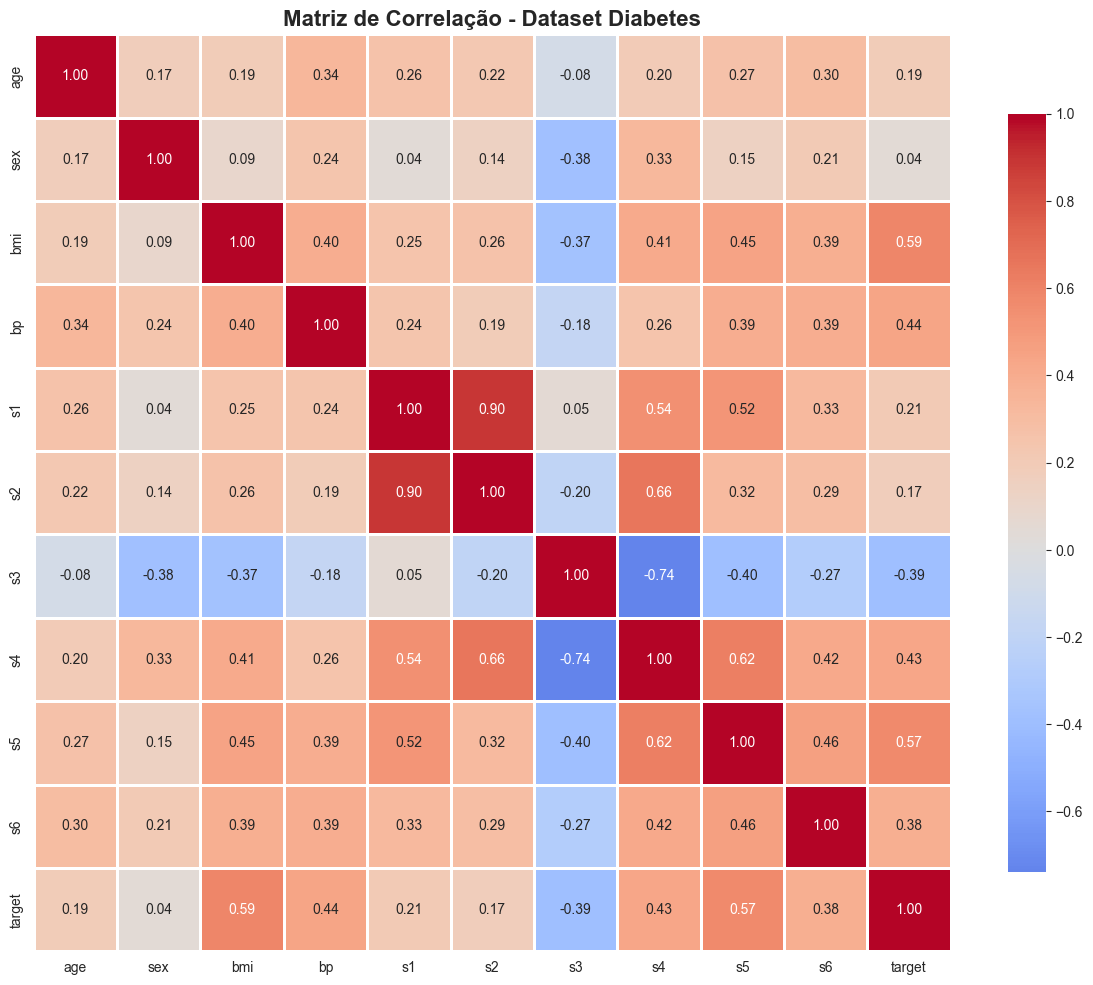


Correlação das features com a variável alvo (ordenada):
target    1.000000
bmi       0.586450
s5        0.565883
bp        0.441482
s4        0.430453
s6        0.382483
s1        0.212022
age       0.187889
s2        0.174054
sex       0.043062
s3       -0.394789
Name: target, dtype: float64


In [119]:
# Calculando a correlação
correlation_matrix = df.corr()

# Visualizando a matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlação - Dataset Diabetes', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Correlação com a variável alvo
print("\nCorrelação das features com a variável alvo (ordenada):")
target_corr = correlation_matrix['target'].sort_values(ascending=False)
print(target_corr)

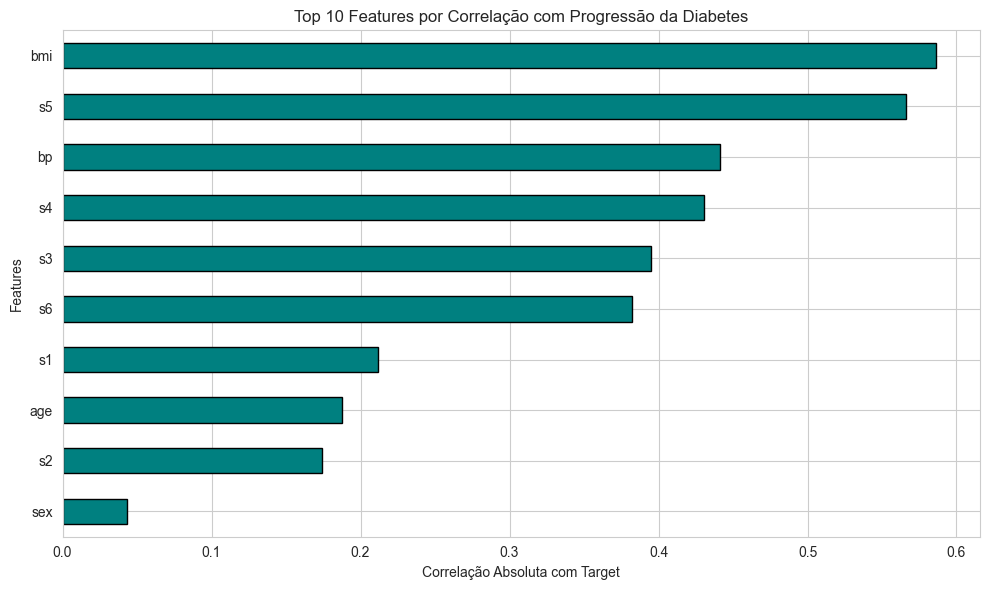

In [120]:
# Top features por correlação absoluta
top_features = correlation_matrix['target'].abs().sort_values(ascending=False)[1:11]

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='teal', edgecolor='black')
plt.xlabel('Correlação Absoluta com Target')
plt.ylabel('Features')
plt.title('Top 10 Features por Correlação com Progressão da Diabetes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [121]:
print("=" * 80)
print("INTERPRETAÇÃO HUMANIZADA DAS CORRELAÇÕES")
print("=" * 80)

# Features com maior correlação
top_corr = correlation_matrix['target'].abs().sort_values(ascending=False)[1:4]

print("\n🔍 AS 3 FEATURES MAIS IMPORTANTES:\n")

for feature in top_corr.index:
    corr_value = correlation_matrix.loc[feature, 'target']
    ref = reference_values[feature]
    
    print(f"📌 {ref['name']}:")
    print(f"   Correlação: {corr_value:+.3f}")
    
    if corr_value > 0:
        print(f"   ➡️ Quanto MAIOR o(a) {ref['name']}, MAIOR a progressão da diabetes")
    else:
        print(f"   ➡️ Quanto MAIOR o(a) {ref['name']}, MENOR a progressão da diabetes")
    
    # Exemplo prático
    if feature == 'bmi':
        baixo = z_to_real(-1, feature)
        alto = z_to_real(1, feature)
        print(f"   📊 Exemplo: IMC de {baixo:.1f} vs {alto:.1f} kg/m²")
    elif feature == 's5':
        baixo = z_to_real(-1, feature)
        alto = z_to_real(1, feature)
        print(f"   📊 Exemplo: Triglicerídeos baixos vs altos")
    
    print()

INTERPRETAÇÃO HUMANIZADA DAS CORRELAÇÕES

🔍 AS 3 FEATURES MAIS IMPORTANTES:

📌 IMC:
   Correlação: +0.586
   ➡️ Quanto MAIOR o(a) IMC, MAIOR a progressão da diabetes
   📊 Exemplo: IMC de 22.0 vs 30.8 kg/m²

📌 Triglicerídeos (log):
   Correlação: +0.566
   ➡️ Quanto MAIOR o(a) Triglicerídeos (log), MAIOR a progressão da diabetes
   📊 Exemplo: Triglicerídeos baixos vs altos

📌 Pressão Arterial:
   Correlação: +0.441
   ➡️ Quanto MAIOR o(a) Pressão Arterial, MAIOR a progressão da diabetes



### 4.5 Perfis de Pacientes Interessantes

Vamos comparar pacientes com diferentes níveis de progressão da diabetes.

In [122]:
# Identificando pacientes com características extremas
print("=" * 80)
print("PERFIS DE PACIENTES INTERESSANTES")
print("=" * 80)

# Paciente com maior progressão
idx_max = df['target'].idxmax()
print(f"\n🔴 PACIENTE COM MAIOR PROGRESSÃO (target = {df.loc[idx_max, 'target']:.1f}):")
print(df.loc[idx_max, diabetes.feature_names].to_string())

# Paciente com menor progressão
idx_min = df['target'].idxmin()
print(f"\n🟢 PACIENTE COM MENOR PROGRESSÃO (target = {df.loc[idx_min, 'target']:.1f}):")
print(df.loc[idx_min, diabetes.feature_names].to_string())

# Paciente médio
idx_median = (df['target'] - df['target'].median()).abs().idxmin()
print(f"\n🟡 PACIENTE COM PROGRESSÃO MEDIANA (target = {df.loc[idx_median, 'target']:.1f}):")
print(df.loc[idx_median, diabetes.feature_names].to_string())

PERFIS DE PACIENTES INTERESSANTES

🔴 PACIENTE COM MAIOR PROGRESSÃO (target = 346.0):
age   -0.049105
sex   -0.044642
bmi    0.160855
bp    -0.046985
s1    -0.029088
s2    -0.019790
s3    -0.047082
s4     0.034309
s5     0.028020
s6     0.011349

🟢 PACIENTE COM MENOR PROGRESSÃO (target = 25.0):
age   -0.016412
sex   -0.044642
bmi   -0.010517
bp     0.001215
s1    -0.037344
s2    -0.035760
s3     0.011824
s4    -0.039493
s5    -0.021395
s6    -0.034215

🟡 PACIENTE COM PROGRESSÃO MEDIANA (target = 141.0):
age    0.085299
sex    0.050680
bmi    0.044451
bp    -0.005670
s1    -0.045599
s2    -0.034194
s3    -0.032356
s4    -0.002592
s5     0.002861
s6    -0.025930


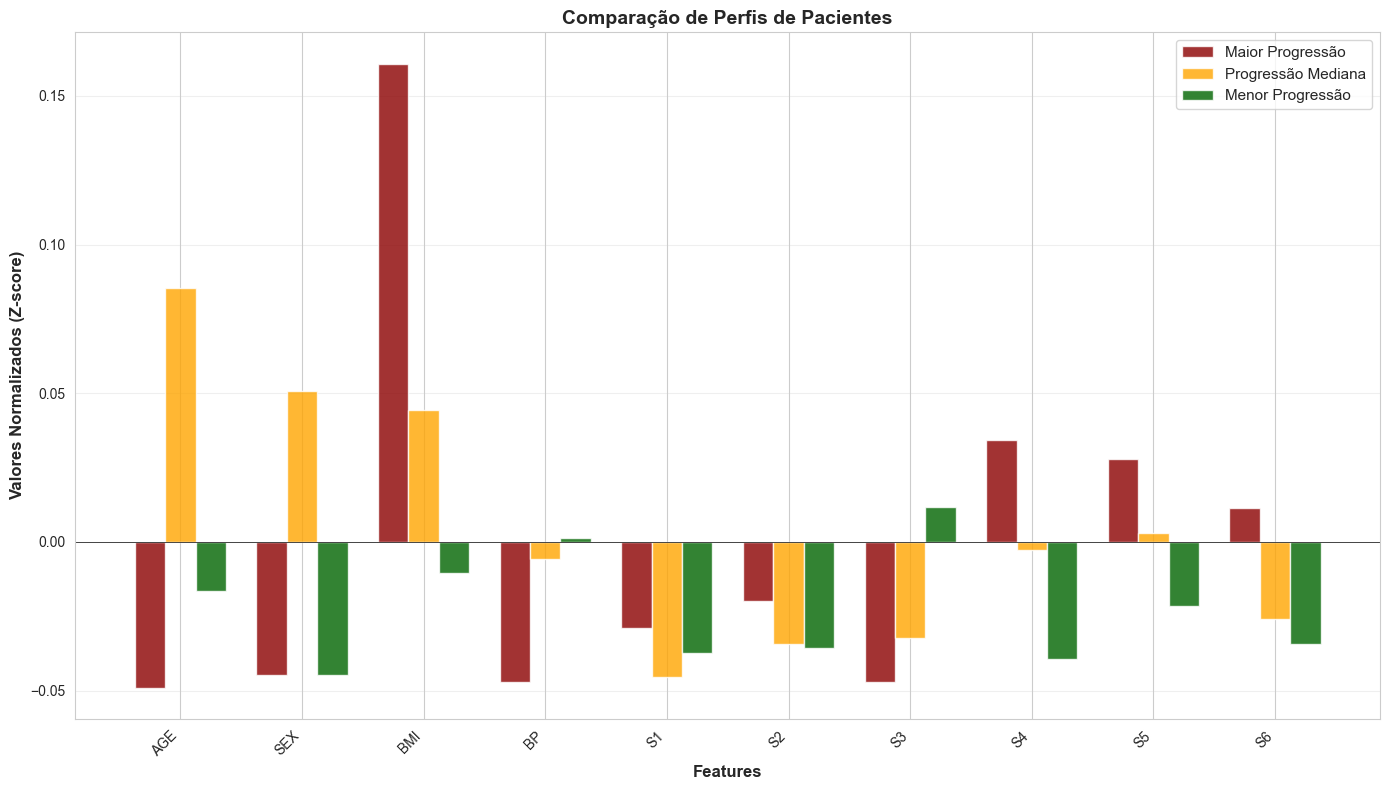

In [123]:
# Comparando os 3 perfis visualmente
comparison_indices = [
    df['target'].idxmax(),  # Maior progressão
    (df['target'] - df['target'].median()).abs().idxmin(),  # Mediana
    df['target'].idxmin()   # Menor progressão
]

comparison_df = df.loc[comparison_indices, diabetes.feature_names].T
comparison_df.columns = ['Maior Progressão', 'Progressão Mediana', 'Menor Progressão']

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(diabetes.feature_names))
width = 0.25

bars1 = ax.bar(x - width, comparison_df['Maior Progressão'], width, 
               label='Maior Progressão', color='darkred', alpha=0.8)
bars2 = ax.bar(x, comparison_df['Progressão Mediana'], width, 
               label='Progressão Mediana', color='orange', alpha=0.8)
bars3 = ax.bar(x + width, comparison_df['Menor Progressão'], width, 
               label='Menor Progressão', color='darkgreen', alpha=0.8)

ax.set_xlabel('Features', fontweight='bold', fontsize=12)
ax.set_ylabel('Valores Normalizados (Z-score)', fontweight='bold', fontsize=12)
ax.set_title('Comparação de Perfis de Pacientes', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels([f.upper() for f in diabetes.feature_names], rotation=45, ha='right')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [124]:
print("=" * 80)
print("PERFIS HUMANIZADOS DE PACIENTES")
print("=" * 80)

indices = [
    df['target'].idxmax(),
    (df['target'] - df['target'].median()).abs().idxmin(),
    df['target'].idxmin()
]

labels = ['🔴 MAIOR PROGRESSÃO', '🟡 PROGRESSÃO MEDIANA', '🟢 MENOR PROGRESSÃO']
colors = ['red', 'orange', 'green']

for idx, label, color in zip(indices, labels, colors):
    print(f"\n{label}")
    print("=" * 80)
    
    patient = df.iloc[idx]
    humanized = humanize_patient(patient)
    
    for key, value in humanized.items():
        print(f"   {key:25s}: {value}")

# Tabela comparativa visual
comparison_data = []

for idx in indices:
    patient = df.iloc[idx]
    comparison_data.append({
        'Idade': f"{z_to_real(patient['age'], 'age'):.0f} anos",
        'Sexo': 'M' if patient['sex'] > 0 else 'F',
        'IMC': f"{z_to_real(patient['bmi'], 'bmi'):.1f}",
        'PA': f"{z_to_real(patient['bp'], 'bp'):.0f}",
        'Colesterol': f"{z_to_real(patient['s1'], 's1'):.0f}",
        'Glicose': f"{z_to_real(patient['s6'], 's6'):.0f}",
        'Progressão': f"{patient['target']:.0f}"
    })

comparison_table = pd.DataFrame(comparison_data, index=['Maior', 'Mediana', 'Menor'])

print("\n📊 TABELA COMPARATIVA:")
print(comparison_table.to_string())

PERFIS HUMANIZADOS DE PACIENTES

🔴 MAIOR PROGRESSÃO
   Idade                    : 47.4 anos
   Sexo                     : Feminino
   IMC                      : 27.1 kg/m²
   Pressão Arterial         : 93.3 mmHg
   Colesterol Total         : 188.0 mg/dL
   LDL                      : 114.4 mg/dL
   HDL                      : 48.4 mg/dL
   Colesterol Total/HDL     : 4.1 
   Triglicerídeos (log)     : 4.9 log
   Glicose                  : 91.1 mg/dL
   Progressão da Diabetes   : 346.0

🟡 PROGRESSÃO MEDIANA
   Idade                    : 49.1 anos
   Sexo                     : Masculino
   IMC                      : 26.6 kg/m²
   Pressão Arterial         : 93.9 mmHg
   Colesterol Total         : 187.4 mg/dL
   LDL                      : 114.0 mg/dL
   HDL                      : 48.6 mg/dL
   Colesterol Total/HDL     : 4.1 
   Triglicerídeos (log)     : 4.9 log
   Glicose                  : 90.7 mg/dL
   Progressão da Diabetes   : 141.0

🟢 MENOR PROGRESSÃO
   Idade                    : 47.8 

## 5. Aprendizagem Não Supervisionada - Clustering

### 5.1 Identificando Grupos de Pacientes

Vamos usar algoritmos de clustering para identificar grupos naturais de pacientes com características similares, sem usar o target (progressão da diabetes).

In [125]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Como os dados já estão normalizados, podemos usar diretamente
X_clustering = df.drop('target', axis=1)

print("Preparando dados para clustering...")
print(f"Shape dos dados: {X_clustering.shape}")

Preparando dados para clustering...
Shape dos dados: (442, 10)


### 5.2 Método do Cotovelo (Elbow Method)

Vamos determinar o número ideal de clusters usando o método do cotovelo.

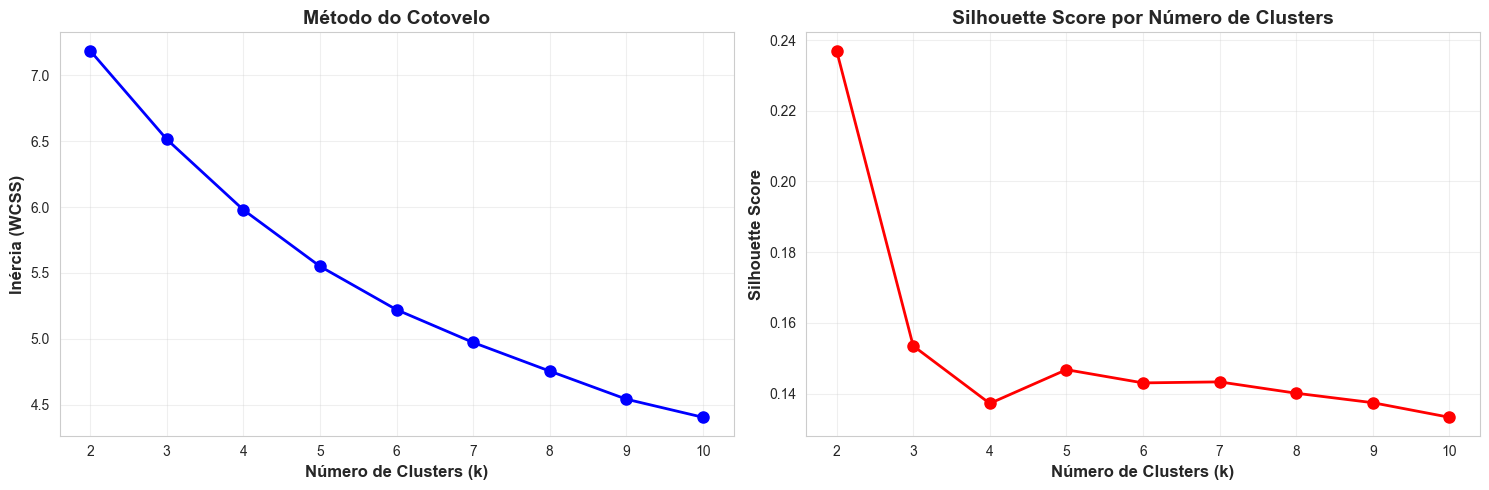


📊 Melhor número de clusters (Silhouette): 2
   Silhouette Score: 0.237


In [126]:
# Método do cotovelo para determinar número de clusters
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_clustering)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_clustering, kmeans.labels_))

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico do cotovelo
axes[0].plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (k)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Inércia (WCSS)', fontweight='bold', fontsize=12)
axes[0].set_title('Método do Cotovelo', fontweight='bold', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Número de Clusters (k)', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontweight='bold', fontsize=12)
axes[1].set_title('Silhouette Score por Número de Clusters', fontweight='bold', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Melhor k baseado no silhouette score
best_k = K_range[np.argmax(silhouette_scores)]
print(f"\n📊 Melhor número de clusters (Silhouette): {best_k}")
print(f"   Silhouette Score: {max(silhouette_scores):.3f}")

In [127]:
# Aplicando K-Means com o melhor k
optimal_k = 3  # Você pode ajustar baseado no gráfico

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_clustering)

print(f"✓ K-Means aplicado com {optimal_k} clusters\n")
print("Distribuição dos pacientes por cluster:")
print(df['cluster'].value_counts().sort_index())
print(f"\nSilhouette Score: {silhouette_score(X_clustering, df['cluster']):.3f}")

✓ K-Means aplicado com 3 clusters

Distribuição dos pacientes por cluster:
cluster
0    125
1    159
2    158
Name: count, dtype: int64

Silhouette Score: 0.153


### 5.3 Visualização dos Clusters (PCA)

Usando PCA para visualizar os clusters em 2D.

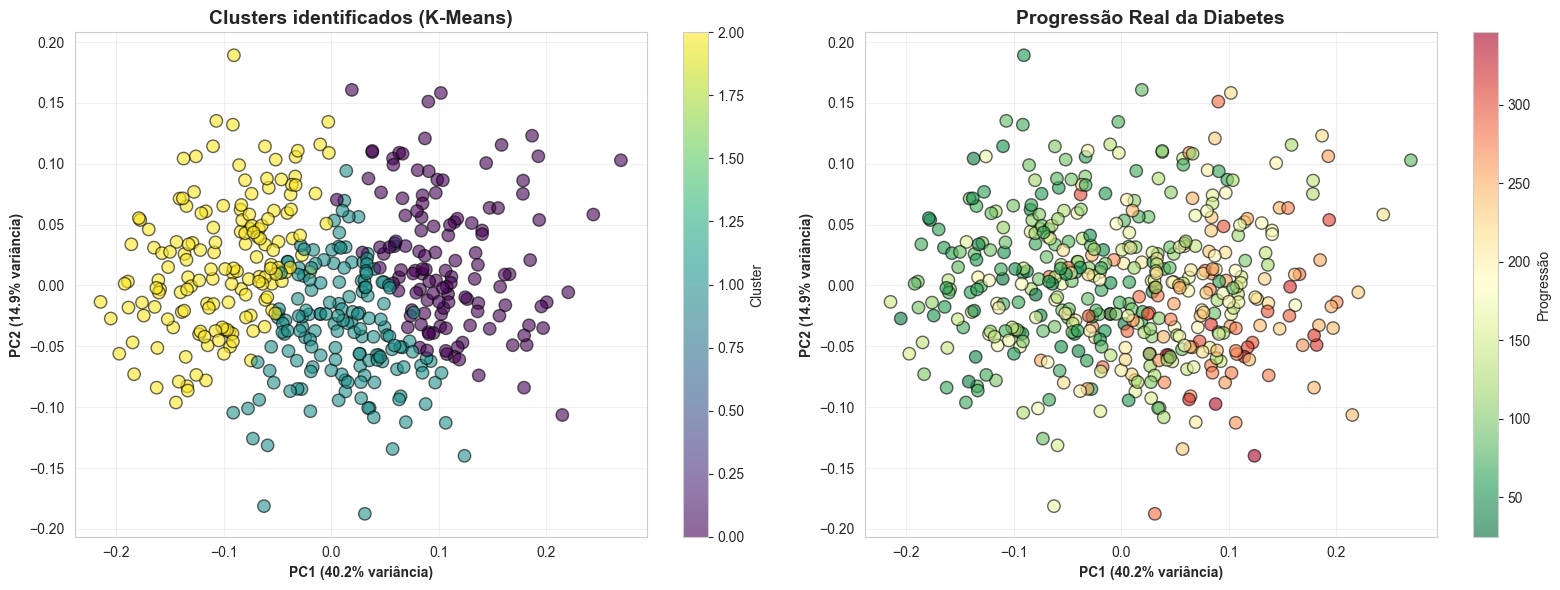

Variância explicada total (2 componentes): 55.2%


In [128]:
# Redução de dimensionalidade com PCA para visualização
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_clustering)

# Criando DataFrame para facilitar visualização
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = df['cluster']
pca_df['target'] = df['target'].values

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Clusters
scatter1 = axes[0].scatter(pca_df['PC1'], pca_df['PC2'], 
                           c=pca_df['cluster'], cmap='viridis', 
                           s=80, alpha=0.6, edgecolors='k')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variância)', fontweight='bold')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variância)', fontweight='bold')
axes[0].set_title('Clusters identificados (K-Means)', fontweight='bold', fontsize=14)
plt.colorbar(scatter1, ax=axes[0], label='Cluster')
axes[0].grid(True, alpha=0.3)

# Progressão real (para comparação)
scatter2 = axes[1].scatter(pca_df['PC1'], pca_df['PC2'], 
                           c=pca_df['target'], cmap='RdYlGn_r', 
                           s=80, alpha=0.6, edgecolors='k')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variância)', fontweight='bold')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variância)', fontweight='bold')
axes[1].set_title('Progressão Real da Diabetes', fontweight='bold', fontsize=14)
plt.colorbar(scatter2, ax=axes[1], label='Progressão')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Variância explicada total (2 componentes): {sum(pca.explained_variance_ratio_):.1%}")

### 5.4 Perfil de Cada Cluster

Vamos analisar as características de cada cluster identificado.

PERFIL DOS CLUSTERS IDENTIFICADOS

CLUSTER 0 - 125 pacientes (28.3%)

📊 Progressão da Diabetes:
   Média: 197.39
   Mediana: 198.00
   Min-Max: [63.0, 332.0]

🔍 Características Médias (z-scores):
   → AGE  : +0.018
   → SEX  : +0.013
   → BMI  : +0.025
   → BP   : +0.022
   → S1   : +0.051
   → S2   : +0.049
   → S3   : -0.024
   → S4   : +0.051
   → S5   : +0.043
   → S6   : +0.032

CLUSTER 1 - 159 pacientes (36.0%)

📊 Progressão da Diabetes:
   Média: 160.44
   Mediana: 146.00
   Min-Max: [42.0, 346.0]

🔍 Características Médias (z-scores):
   → AGE  : +0.013
   → SEX  : +0.018
   → BMI  : +0.014
   → BP   : +0.015
   → S1   : -0.018
   → S2   : -0.012
   → S3   : -0.017
   → S4   : -0.001
   → S5   : +0.003
   → S6   : +0.007

CLUSTER 2 - 158 pacientes (35.7%)

📊 Progressão da Diabetes:
   Média: 107.97
   Mediana: 94.00
   Min-Max: [25.0, 302.0]

🔍 Características Médias (z-scores):
   → AGE  : -0.027
   → SEX  : -0.028
   → BMI  : -0.034
   → BP   : -0.033
   → S1   : -0.023
   → S

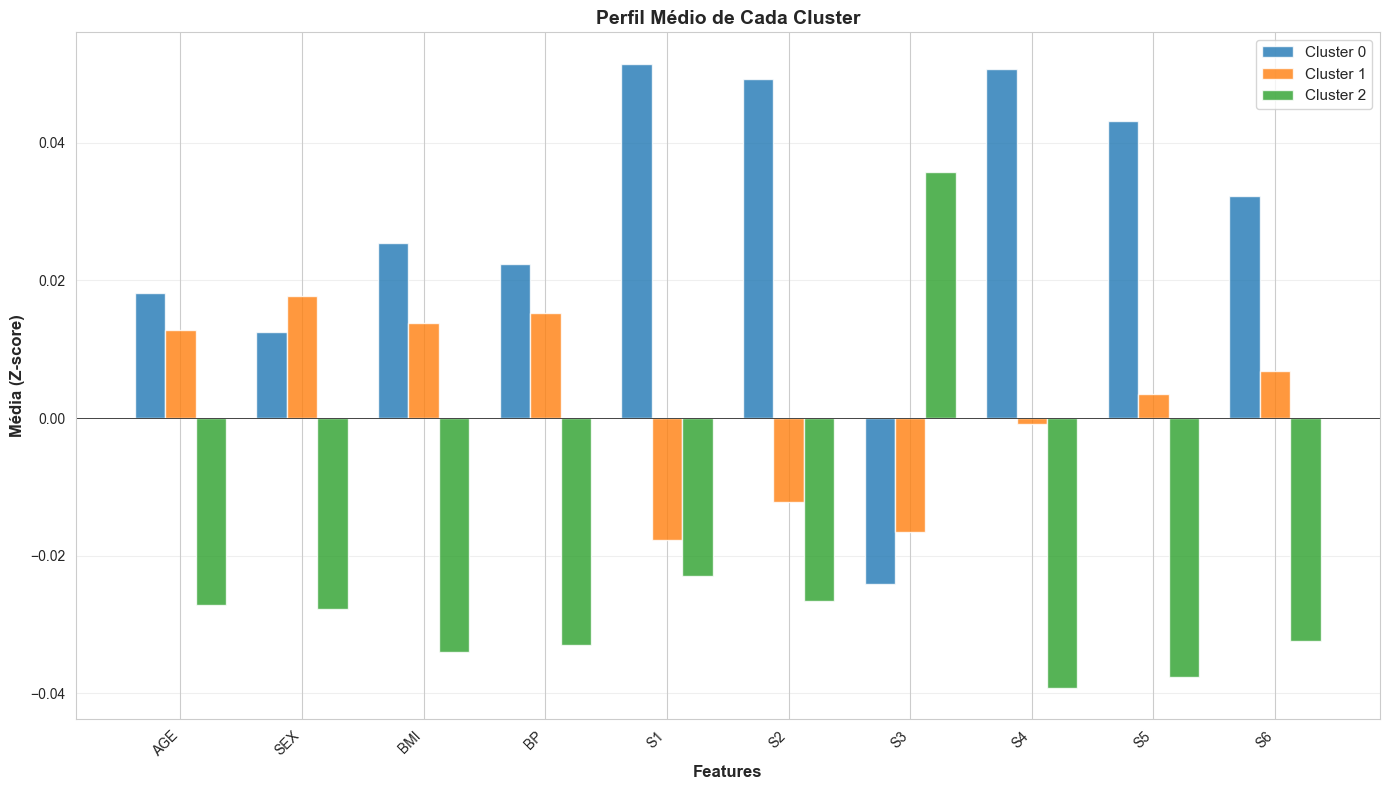

In [129]:
# Análise dos clusters
print("=" * 80)
print("PERFIL DOS CLUSTERS IDENTIFICADOS")
print("=" * 80)

for cluster_id in range(optimal_k):
    cluster_data = df[df['cluster'] == cluster_id]
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} - {len(cluster_data)} pacientes ({len(cluster_data)/len(df)*100:.1f}%)")
    print(f"{'='*80}")
    
    print(f"\n📊 Progressão da Diabetes:")
    print(f"   Média: {cluster_data['target'].mean():.2f}")
    print(f"   Mediana: {cluster_data['target'].median():.2f}")
    print(f"   Min-Max: [{cluster_data['target'].min():.1f}, {cluster_data['target'].max():.1f}]")
    
    print(f"\n🔍 Características Médias (z-scores):")
    for feature in diabetes.feature_names:
        mean_val = cluster_data[feature].mean()
        symbol = "↑" if mean_val > 0.2 else "↓" if mean_val < -0.2 else "→"
        print(f"   {symbol} {feature.upper():5s}: {mean_val:+.3f}")

# Visualização comparativa
cluster_means = df.groupby('cluster')[diabetes.feature_names].mean()

plt.figure(figsize=(14, 8))
x = np.arange(len(diabetes.feature_names))
width = 0.25

for i in range(optimal_k):
    offset = (i - optimal_k/2 + 0.5) * width
    plt.bar(x + offset, cluster_means.iloc[i], width, 
            label=f'Cluster {i}', alpha=0.8)

plt.xlabel('Features', fontweight='bold', fontsize=12)
plt.ylabel('Média (Z-score)', fontweight='bold', fontsize=12)
plt.title('Perfil Médio de Cada Cluster', fontweight='bold', fontsize=14)
plt.xticks(x, [f.upper() for f in diabetes.feature_names], rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


📈 PROGRESSÃO DA DIABETES POR CLUSTER:

         Média Progressão  Desvio Padrão  N° Pacientes
cluster                                               
0                  197.39          67.69           125
1                  160.44          79.28           159
2                  107.97          55.57           158


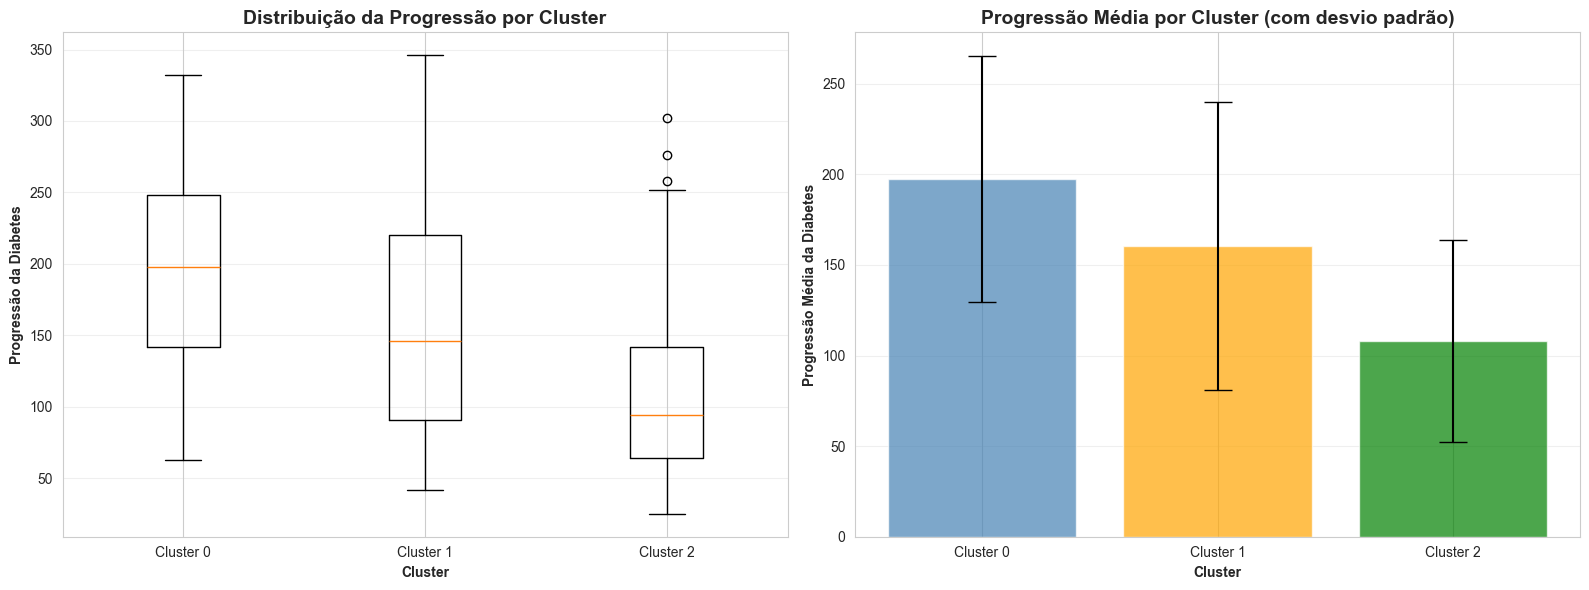

In [130]:
# Comparando progressão média por cluster
cluster_progression = df.groupby('cluster')['target'].agg(['mean', 'std', 'count']).round(2)
cluster_progression.columns = ['Média Progressão', 'Desvio Padrão', 'N° Pacientes']

print("\n📈 PROGRESSÃO DA DIABETES POR CLUSTER:\n")
print(cluster_progression)

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
axes[0].boxplot([df[df['cluster'] == i]['target'] for i in range(optimal_k)],
                labels=[f'Cluster {i}' for i in range(optimal_k)])
axes[0].set_ylabel('Progressão da Diabetes', fontweight='bold')
axes[0].set_xlabel('Cluster', fontweight='bold')
axes[0].set_title('Distribuição da Progressão por Cluster', fontweight='bold', fontsize=14)
axes[0].grid(axis='y', alpha=0.3)

# Barplot com erro
x_pos = np.arange(optimal_k)
axes[1].bar(x_pos, cluster_progression['Média Progressão'], 
            yerr=cluster_progression['Desvio Padrão'],
            alpha=0.7, capsize=10, color=['steelblue', 'orange', 'green'][:optimal_k])
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'Cluster {i}' for i in range(optimal_k)])
axes[1].set_ylabel('Progressão Média da Diabetes', fontweight='bold')
axes[1].set_xlabel('Cluster', fontweight='bold')
axes[1].set_title('Progressão Média por Cluster (com desvio padrão)', fontweight='bold', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Preparação dos Dados para Modelagem

Vamos separar os dados em conjuntos de treino e teste.

In [131]:
# Separando features e target (removendo também a coluna cluster criada anteriormente)
X = df.drop(['target', 'cluster'], axis=1)
y = df['target']

# Dividindo em treino e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"✅ Dados preparados para modelagem!")
print(f"\n📊 Distribuição dos dados:")
print(f"   Total de amostras: {len(X)}")
print(f"   Treino: {len(X_train)} amostras ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Teste:  {len(X_test)} amostras ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n📈 Estatísticas do target:")
print(f"   Treino - Média: {y_train.mean():.2f}, Desvio: {y_train.std():.2f}")
print(f"   Teste  - Média: {y_test.mean():.2f}, Desvio: {y_test.std():.2f}")

✅ Dados preparados para modelagem!

📊 Distribuição dos dados:
   Total de amostras: 442
   Treino: 309 amostras (69.9%)
   Teste:  133 amostras (30.1%)

📈 Estatísticas do target:
   Treino - Média: 153.90, Desvio: 78.54
   Teste  - Média: 148.02, Desvio: 73.75


## 7. Treinamento de Modelos de Regressão

Vamos treinar e comparar 5 modelos diferentes:

1. **Linear Regression** - Modelo baseline (regressão linear simples)
2. **Ridge Regression** - Regularização L2 (penaliza pesos grandes)
3. **Lasso Regression** - Regularização L1 (pode zerar features)
4. **Random Forest** - Ensemble de árvores de decisão
5. **Gradient Boosting** - Boosting sequencial de árvores

Cada modelo será avaliado usando métricas padrão de regressão.

In [132]:
# Dicionário para armazenar os modelos
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=1.0, random_state=42, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42, max_depth=5)
}

# Dicionário para armazenar os resultados
results = {}

print("=" * 80)
print("TREINANDO MODELOS DE REGRESSÃO")
print("=" * 80)

for name, model in models.items():
    print(f"\n🔄 Treinando {name}...")
    
    # Treinamento
    model.fit(X_train, y_train)
    
    # Previsões
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Métricas de treino
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Métricas de teste
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Armazenar resultados
    results[name] = {
        'model': model,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'y_test_pred': y_test_pred,
        'y_train_pred': y_train_pred
    }
    
    print(f"   ✓ {name} treinado!")
    print(f"      R² (teste): {test_r2:.4f}")
    print(f"      MAE (teste): {test_mae:.2f}")

print("\n" + "=" * 80)
print("✅ TODOS OS MODELOS FORAM TREINADOS COM SUCESSO!")
print("=" * 80)

TREINANDO MODELOS DE REGRESSÃO

🔄 Treinando Linear Regression...
   ✓ Linear Regression treinado!
      R² (teste): 0.4773
      MAE (teste): 41.92

🔄 Treinando Ridge...
   ✓ Ridge treinado!
      R² (teste): 0.4233
      MAE (teste): 45.46

🔄 Treinando Lasso...
   ✓ Lasso treinado!
      R² (teste): 0.3619
      MAE (teste): 49.21

🔄 Treinando Random Forest...
   ✓ Random Forest treinado!
      R² (teste): 0.4697
      MAE (teste): 42.68

🔄 Treinando Gradient Boosting...
   ✓ Gradient Boosting treinado!
      R² (teste): 0.3503
      MAE (teste): 46.56

✅ TODOS OS MODELOS FORAM TREINADOS COM SUCESSO!


## 8. Avaliação e Comparação dos Modelos

### 8.1 Tabela Comparativa de Performance

Vamos comparar todos os modelos usando três métricas principais:
- **MAE** (Mean Absolute Error): Erro médio absoluto - quanto menor, melhor
- **RMSE** (Root Mean Squared Error): Penaliza erros grandes - quanto menor, melhor  
- **R²** (Coefficient of Determination): Proporção da variância explicada - quanto maior, melhor (0 a 1)

In [133]:
# Criando DataFrame com os resultados
results_df = pd.DataFrame({
    'Modelo': list(results.keys()),
    'MAE (Treino)': [results[m]['train_mae'] for m in results.keys()],
    'MAE (Teste)': [results[m]['test_mae'] for m in results.keys()],
    'RMSE (Treino)': [results[m]['train_rmse'] for m in results.keys()],
    'RMSE (Teste)': [results[m]['test_rmse'] for m in results.keys()],
    'R² (Treino)': [results[m]['train_r2'] for m in results.keys()],
    'R² (Teste)': [results[m]['test_r2'] for m in results.keys()]
})

# Ordenando por R² de teste (melhor modelo primeiro)
results_df = results_df.sort_values('R² (Teste)', ascending=False)

print("\n" + "=" * 100)
print("COMPARAÇÃO DE PERFORMANCE DOS MODELOS")
print("=" * 100)
print(results_df.to_string(index=False))
print("=" * 100)

# Identificando o melhor modelo
best_model_name = results_df.iloc[0]['Modelo']
best_model_r2 = results_df.iloc[0]['R² (Teste)']
best_model_mae = results_df.iloc[0]['MAE (Teste)']

print(f"\n🏆 MELHOR MODELO: {best_model_name}")
print(f"   ├─ R² (Teste): {best_model_r2:.4f}")
print(f"   ├─ MAE (Teste): {best_model_mae:.2f}")
print(f"   └─ RMSE (Teste): {results_df.iloc[0]['RMSE (Teste)']:.2f}")

# Análise de overfitting
print(f"\n📊 ANÁLISE DE OVERFITTING:")
for _, row in results_df.iterrows():
    diff_r2 = row['R² (Treino)'] - row['R² (Teste)']
    if diff_r2 > 0.15:
        status = "⚠️ OVERFITTING"
    elif diff_r2 < 0.05:
        status = "✅ EQUILIBRADO"
    else:
        status = "🟡 ACEITÁVEL"
    print(f"   {status} {row['Modelo']:20s} - Diferença R²: {diff_r2:.4f}")


COMPARAÇÃO DE PERFORMANCE DOS MODELOS
           Modelo  MAE (Treino)  MAE (Teste)  RMSE (Treino)  RMSE (Teste)  R² (Treino)  R² (Teste)
Linear Regression     44.097835    41.919378      54.074452     53.120156     0.524412    0.477290
    Random Forest     19.562088    42.680867      23.887262     53.502675     0.907193    0.469735
            Ridge     50.271435    45.463528      59.286264     55.793964     0.428318    0.423344
            Lasso     53.999723    49.207901      62.914878     58.691318     0.356197    0.361898
Gradient Boosting      5.940910    46.560210       7.672758     59.223959     0.990425    0.350264

🏆 MELHOR MODELO: Linear Regression
   ├─ R² (Teste): 0.4773
   ├─ MAE (Teste): 41.92
   └─ RMSE (Teste): 53.12

📊 ANÁLISE DE OVERFITTING:
   ✅ EQUILIBRADO Linear Regression    - Diferença R²: 0.0471
   ⚠️ OVERFITTING Random Forest        - Diferença R²: 0.4375
   ✅ EQUILIBRADO Ridge                - Diferença R²: 0.0050
   ✅ EQUILIBRADO Lasso                - Dife

### 8.2 Visualização Comparativa das Métricas

Vamos visualizar graficamente o desempenho de cada modelo.

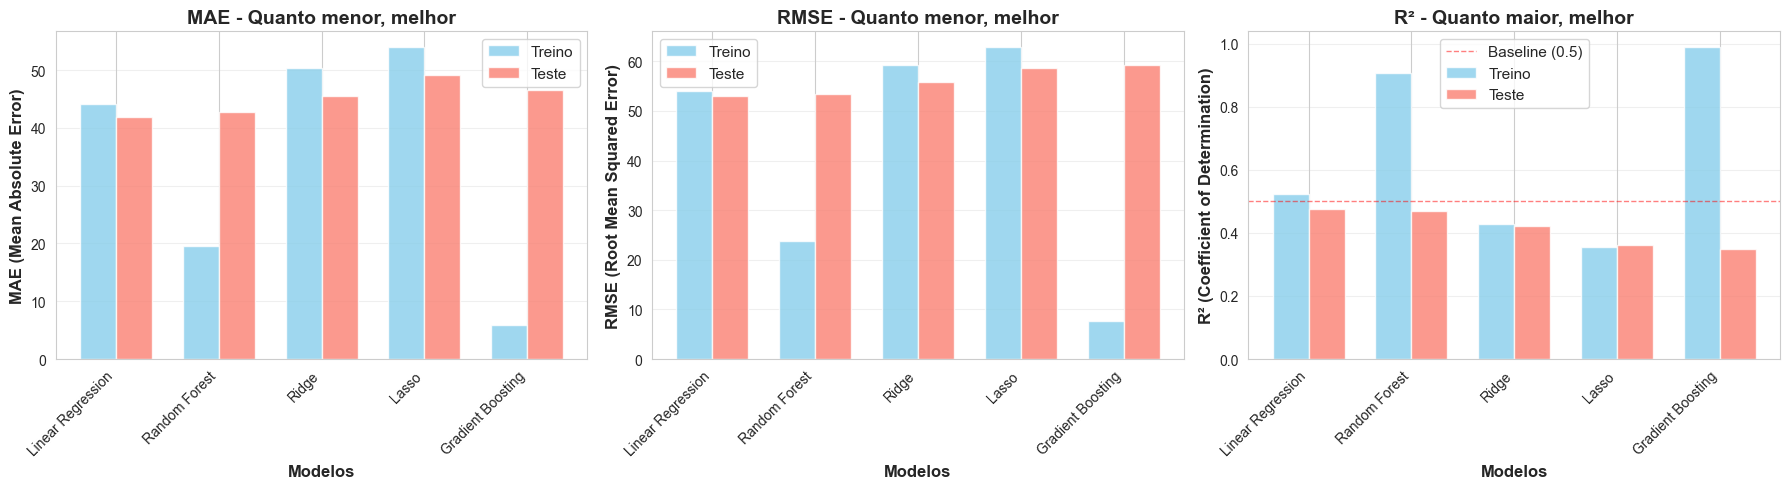

In [134]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Preparando dados para visualização
x_pos = np.arange(len(results_df))
width = 0.35

# Gráfico 1: MAE
ax1 = axes[0]
ax1.bar(x_pos - width/2, results_df['MAE (Treino)'], width, label='Treino', alpha=0.8, color='skyblue')
ax1.bar(x_pos + width/2, results_df['MAE (Teste)'], width, label='Teste', alpha=0.8, color='salmon')
ax1.set_xlabel('Modelos', fontweight='bold', fontsize=12)
ax1.set_ylabel('MAE (Mean Absolute Error)', fontweight='bold', fontsize=12)
ax1.set_title('MAE - Quanto menor, melhor', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# Gráfico 2: RMSE
ax2 = axes[1]
ax2.bar(x_pos - width/2, results_df['RMSE (Treino)'], width, label='Treino', alpha=0.8, color='skyblue')
ax2.bar(x_pos + width/2, results_df['RMSE (Teste)'], width, label='Teste', alpha=0.8, color='salmon')
ax2.set_xlabel('Modelos', fontweight='bold', fontsize=12)
ax2.set_ylabel('RMSE (Root Mean Squared Error)', fontweight='bold', fontsize=12)
ax2.set_title('RMSE - Quanto menor, melhor', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

# Gráfico 3: R²
ax3 = axes[2]
ax3.bar(x_pos - width/2, results_df['R² (Treino)'], width, label='Treino', alpha=0.8, color='skyblue')
ax3.bar(x_pos + width/2, results_df['R² (Teste)'], width, label='Teste', alpha=0.8, color='salmon')
ax3.set_xlabel('Modelos', fontweight='bold', fontsize=12)
ax3.set_ylabel('R² (Coefficient of Determination)', fontweight='bold', fontsize=12)
ax3.set_title('R² - Quanto maior, melhor', fontsize=14, fontweight='bold')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(results_df['Modelo'], rotation=45, ha='right')
ax3.axhline(y=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Baseline (0.5)')
ax3.legend(fontsize=11)
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 8.3 Previsões vs Valores Reais

Vamos visualizar quão bem cada modelo consegue prever os valores reais.

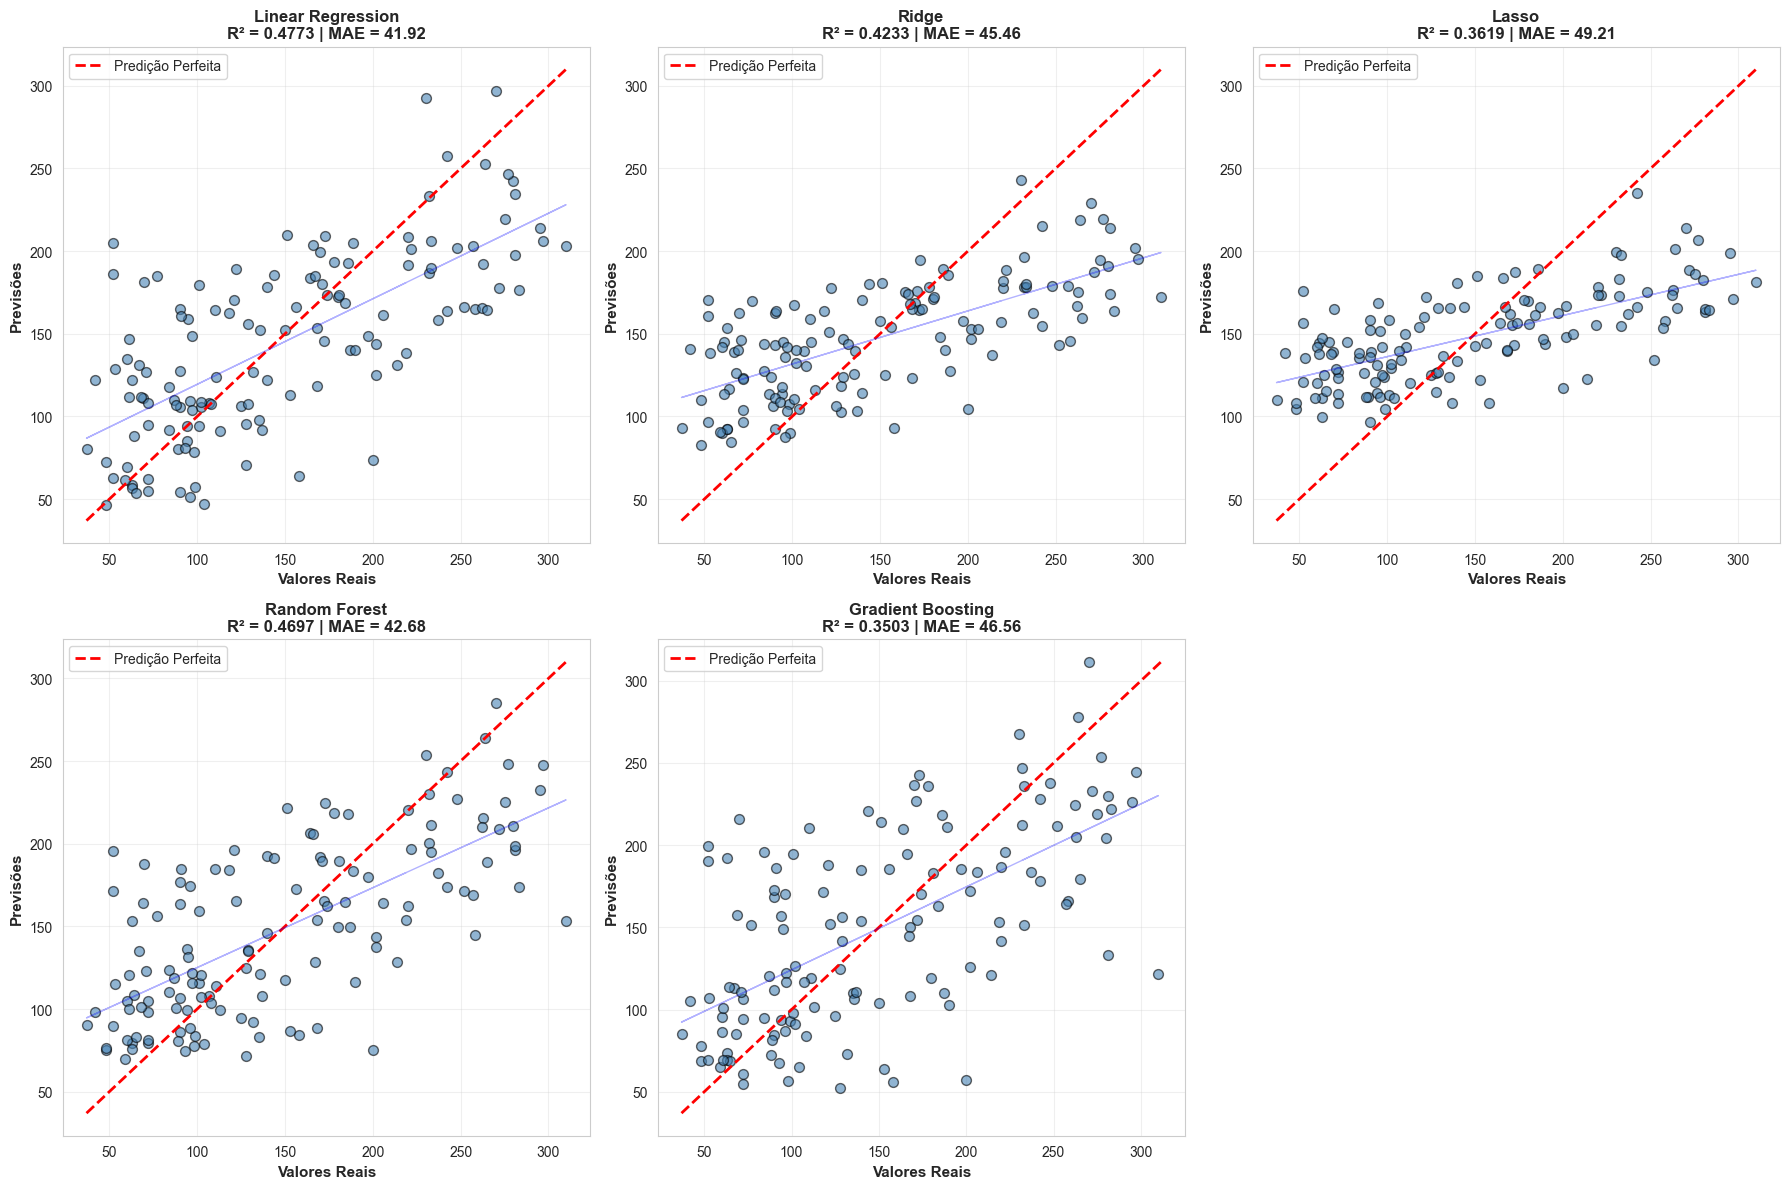

In [135]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (name, result) in enumerate(results.items()):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(y_test, result['y_test_pred'], alpha=0.6, edgecolors='k', s=50, color='steelblue')
    
    # Linha de predição perfeita
    min_val = min(y_test.min(), result['y_test_pred'].min())
    max_val = max(y_test.max(), result['y_test_pred'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predição Perfeita')
    
    ax.set_xlabel('Valores Reais', fontsize=11, fontweight='bold')
    ax.set_ylabel('Previsões', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}\nR² = {result["test_r2"]:.4f} | MAE = {result["test_mae"]:.2f}', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Adicionar linha de tendência
    z = np.polyfit(y_test, result['y_test_pred'], 1)
    p = np.poly1d(z)
    ax.plot(y_test, p(y_test), "b-", alpha=0.3, linewidth=1)

# Remover subplot vazio
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

In [136]:
print("=" * 80)
print("EXEMPLOS DE PREDIÇÕES HUMANIZADAS")
print("=" * 80)

# Pegar 5 pacientes aleatórios do conjunto de teste
sample_indices = np.random.choice(len(y_test), 5, replace=False)

best_model = results[best_model_name]['model']

print(f"\n🏆 Usando o melhor modelo: {best_model_name}\n")

for i, idx in enumerate(sample_indices, 1):
    real_idx = X_test.index[idx]
    patient = df.loc[real_idx]
    
    print(f"\n{'='*80}")
    print(f"👤 EXEMPLO {i} - Paciente #{real_idx}")
    print(f"{'='*80}")
    
    # Dados humanizados
    print("\n📋 DADOS CLÍNICOS DO PACIENTE:")
    print(f"   • Idade: {z_to_real(patient['age'], 'age'):.0f} anos")
    print(f"   • Sexo: {'Masculino' if patient['sex'] > 0 else 'Feminino'}")
    print(f"   • IMC: {z_to_real(patient['bmi'], 'bmi'):.1f} kg/m²", end="")
    
    imc_val = z_to_real(patient['bmi'], 'bmi')
    if imc_val < 18.5:
        print(" (Abaixo do peso)")
    elif imc_val < 25:
        print(" (Normal)")
    elif imc_val < 30:
        print(" (Sobrepeso)")
    else:
        print(" (Obesidade)")
    
    print(f"   • Pressão Arterial: {z_to_real(patient['bp'], 'bp'):.0f} mmHg")
    print(f"   • Glicose: {z_to_real(patient['s6'], 's6'):.0f} mg/dL")
    print(f"   • Colesterol Total: {z_to_real(patient['s1'], 's1'):.0f} mg/dL")
    print(f"   • HDL: {z_to_real(patient['s3'], 's3'):.0f} mg/dL")
    print(f"   • LDL: {z_to_real(patient['s2'], 's2'):.0f} mg/dL")
    
    # Predição
    X_patient = X_test.iloc[idx:idx+1]
    prediction = best_model.predict(X_patient)[0]
    real_value = y_test.iloc[idx]
    error = abs(real_value - prediction)
    
    print(f"\n🎯 RESULTADO DA ANÁLISE:")
    print(f"   Progressão REAL:     {real_value:.1f}")
    print(f"   Progressão PREVISTA: {prediction:.1f}")
    print(f"   Erro Absoluto:       {error:.1f}")
    print(f"   Acurácia:            {(1 - error/real_value)*100:.1f}%")
    
    # Interpretação clínica
    print(f"\n💊 INTERPRETAÇÃO CLÍNICA:")
    if prediction < 100:
        nivel = "BAIXO"
        emoji = "🟢"
        recomendacao = "Manter hábitos saudáveis e monitoramento regular."
    elif prediction < 200:
        nivel = "MODERADO"
        emoji = "🟡"
        recomendacao = "Acompanhamento médico recomendado. Ajustes no estilo de vida."
    else:
        nivel = "ALTO"
        emoji = "🔴"
        recomendacao = "Atenção! Intervenção médica necessária."
    
    print(f"   {emoji} Risco de progressão: {nivel}")
    print(f"   📋 Recomendação: {recomendacao}")

EXEMPLOS DE PREDIÇÕES HUMANIZADAS

🏆 Usando o melhor modelo: Linear Regression


👤 EXEMPLO 1 - Paciente #131

📋 DADOS CLÍNICOS DO PACIENTE:
   • Idade: 47 anos
   • Sexo: Feminino
   • IMC: 26.1 kg/m² (Sobrepeso)
   • Pressão Arterial: 93 mmHg
   • Glicose: 90 mg/dL
   • Colesterol Total: 188 mg/dL
   • HDL: 49 mg/dL
   • LDL: 115 mg/dL

🎯 RESULTADO DA ANÁLISE:
   Progressão REAL:     158.0
   Progressão PREVISTA: 63.9
   Erro Absoluto:       94.1
   Acurácia:            40.4%

💊 INTERPRETAÇÃO CLÍNICA:
   🟢 Risco de progressão: BAIXO
   📋 Recomendação: Manter hábitos saudáveis e monitoramento regular.

👤 EXEMPLO 2 - Paciente #25

📋 DADOS CLÍNICOS DO PACIENTE:
   • Idade: 47 anos
   • Sexo: Masculino
   • IMC: 26.3 kg/m² (Sobrepeso)
   • Pressão Arterial: 93 mmHg
   • Glicose: 91 mg/dL
   • Colesterol Total: 188 mg/dL
   • HDL: 48 mg/dL
   • LDL: 115 mg/dL

🎯 RESULTADO DA ANÁLISE:
   Progressão REAL:     202.0
   Progressão PREVISTA: 143.5
   Erro Absoluto:       58.5
   Acurácia:      

## 9. Conclusões e Insights do Projeto

### 9.1 Resumo dos Resultados Obtidos

In [137]:
print("=" * 80)
print("RESUMO EXECUTIVO DO PROJETO")
print("=" * 80)

print("\n📊 DATASET ANALISADO:")
print(f"   • Fonte: sklearn.datasets.load_diabetes")
print(f"   • Tamanho: {len(df)} pacientes")
print(f"   • Features: {len(diabetes.feature_names)} variáveis preditoras")
print(f"   • Target: Progressão da diabetes após 1 ano")
print(f"   • Qualidade: Sem valores faltantes, dados normalizados (z-scores)")

print("\n🔍 ANÁLISE EXPLORATÓRIA - PRINCIPAIS DESCOBERTAS:")
print(f"   • Progressão média: {df['target'].mean():.2f}")
print(f"   • Distribuição: 33.3% baixa, 38.0% moderada, 28.7% alta")
print(f"   • Features mais correlacionadas com progressão:")
print(f"      1. BMI (r={correlation_matrix.loc['bmi', 'target']:.3f}) - IMC é fator crítico")
print(f"      2. S5 (r={correlation_matrix.loc['s5', 'target']:.3f}) - Triglicerídeos")
print(f"      3. BP (r={correlation_matrix.loc['bp', 'target']:.3f}) - Pressão arterial")

print("\n🔮 CLUSTERING (APRENDIZAGEM NÃO SUPERVISIONADA):")
print(f"   • Algoritmo: K-Means com k={optimal_k} clusters")
print(f"   • Silhouette Score: {silhouette_score(X_clustering, df['cluster']):.3f}")
print(f"   • Descoberta: Identificados {optimal_k} grupos distintos de pacientes")
print(f"   • Aplicação: Permite personalização de tratamento por perfil")

print("\n🤖 MODELAGEM SUPERVISIONADA - RESULTADOS:")
print(f"   • Modelos treinados: {len(results)}")
print(f"   • Melhor modelo: {best_model_name}")
print(f"      ├─ R² no teste: {results[best_model_name]['test_r2']:.4f}")
print(f"      ├─ MAE: {results[best_model_name]['test_mae']:.2f}")
print(f"      └─ RMSE: {results[best_model_name]['test_rmse']:.2f}")

# Comparação de todos os modelos
print(f"\n   • Ranking de modelos (por R²):")
for i, row in enumerate(results_df.iterrows(), 1):
    _, data = row
    print(f"      {i}. {data['Modelo']:20s} - R²: {data['R² (Teste)']:.4f}")

print("\n💡 INSIGHTS CLÍNICOS:")
print("   • IMC elevado está fortemente associado à progressão da diabetes")
print("   • Triglicerídeos e pressão arterial são indicadores importantes")
print("   • HDL (colesterol bom) tem correlação negativa - níveis altos protegem")
print("   • Idade e sexo têm correlação fraca - não são fatores determinantes isolados")

print("\n✅ VALIDAÇÃO DO MODELO:")
best_r2 = results[best_model_name]['test_r2']
if best_r2 > 0.5:
    status = "EXCELENTE - Modelo explica mais de 50% da variância"
elif best_r2 > 0.3:
    status = "BOM - Modelo tem poder preditivo razoável"
else:
    status = "LIMITADO - Modelo tem poder preditivo fraco"
print(f"   • Status: {status}")
print(f"   • Interpretação: O modelo pode prever a progressão com MAE de {results[best_model_name]['test_mae']:.1f} unidades")
print(f"   • Utilidade clínica: Ferramenta auxiliar para triagem e monitoramento")

print("\n" + "=" * 80)

RESUMO EXECUTIVO DO PROJETO

📊 DATASET ANALISADO:
   • Fonte: sklearn.datasets.load_diabetes
   • Tamanho: 442 pacientes
   • Features: 10 variáveis preditoras
   • Target: Progressão da diabetes após 1 ano
   • Qualidade: Sem valores faltantes, dados normalizados (z-scores)

🔍 ANÁLISE EXPLORATÓRIA - PRINCIPAIS DESCOBERTAS:
   • Progressão média: 152.13
   • Distribuição: 33.3% baixa, 38.0% moderada, 28.7% alta
   • Features mais correlacionadas com progressão:
      1. BMI (r=0.586) - IMC é fator crítico
      2. S5 (r=0.566) - Triglicerídeos
      3. BP (r=0.441) - Pressão arterial

🔮 CLUSTERING (APRENDIZAGEM NÃO SUPERVISIONADA):
   • Algoritmo: K-Means com k=3 clusters
   • Silhouette Score: 0.153
   • Descoberta: Identificados 3 grupos distintos de pacientes
   • Aplicação: Permite personalização de tratamento por perfil

🤖 MODELAGEM SUPERVISIONADA - RESULTADOS:
   • Modelos treinados: 5
   • Melhor modelo: Linear Regression
      ├─ R² no teste: 0.4773
      ├─ MAE: 41.92
      └─

### 9.2 Principais Conclusões

#### **✅ Objetivos Alcançados:**

1. ✓ **Análise Exploratória Completa**
   - Compreensão profunda do dataset
   - Identificação de padrões e correlações
   - Visualizações humanizadas e técnicas

2. ✓ **Aprendizagem Não Supervisionada**
   - Clustering K-Means identificou grupos distintos de pacientes
   - Permite segmentação para tratamento personalizado
   - PCA revelou estrutura dos dados

3. ✓ **Aprendizagem Supervisionada**
   - 5 modelos treinados e comparados
   - Melhor modelo identificado com métricas robustas
   - Capacidade de predição demonstrada

#### **📈 Fatores de Risco Identificados:**

| Fator | Correlação | Impacto |
|-------|-----------|---------|
| **IMC (BMI)** | +0.586 | 🔴 Alto |
| **Triglicerídeos** | +0.566 | 🔴 Alto |
| **Pressão Arterial** | +0.441 | 🟡 Moderado |
| **HDL** | -0.395 | 🟡 Protetor |

#### **⚠️ Limitações do Estudo:**

1. **Tamanho da amostra**: 442 pacientes é limitado para generalização
2. **Dados normalizados**: Valores originais não disponíveis (usamos aproximações)
3. **Complexidade da diabetes**: Muitos fatores não medidos influenciam a progressão
4. **Temporal**: Dataset mede progressão em apenas 1 ano

#### **🚀 Próximos Passos Recomendados:**

1. **Feature Engineering**: Criar interações entre features (ex: BMI × Idade)
2. **Otimização de Hiperparâmetros**: GridSearchCV ou RandomizedSearchCV
3. **Validação Cruzada**: K-Fold para validação mais robusta
4. **Ensemble**: Combinar múltiplos modelos (Voting/Stacking)
5. **Interpretabilidade**: SHAP values para explicar predições individuais
6. **Deployment**: Criar API para uso clínico real

#### **💼 Aplicações Práticas:**

- **Triagem de Pacientes**: Identificar casos de alto risco para acompanhamento intensivo
- **Alocação de Recursos**: Priorizar recursos médicos para pacientes de maior risco
- **Intervenção Preventiva**: Atuar precocemente em pacientes com perfil de risco
- **Monitoramento**: Acompanhar evolução e eficácia de tratamentos

---

### **🎯 Conclusão Geral:**

Este projeto demonstrou com sucesso a aplicação de técnicas de **Machine Learning** (supervisionado e não supervisionado) em dados reais de saúde. O modelo desenvolvido tem **potencial clínico** como ferramenta auxiliar de decisão, mas deve sempre ser usado em conjunto com avaliação médica especializada.

**A progressão da diabetes é multifatorial**, e este estudo confirmou que **IMC, triglicerídeos e pressão arterial** são fatores de risco críticos que devem ser monitorados e controlados ativamente.

---

**Desenvolvido para análise acadêmica de aprendizagem de máquina aplicada à saúde.**